# About

This notebook demonstrates how to solve the dispersion relation for 2D phononic structures using FEniCSx and `dolfinx_mpc` using an indirect $\omega(\boldsymbol{\kappa})$ method.

# Theory

Waves traveling in elastic structures are governed by the wave equation of motion:

$$
\nabla \cdot [\mathbb{C}(\boldsymbol{x}) : \nabla_s \boldsymbol{u}(x, t)] = \rho(\boldsymbol{x}) \ddot{\boldsymbol{u}}(x, t) \, ,
$$

where $\nabla_s$ denotes the symmetric gradient, $\nabla_s \boldsymbol{u} = \frac{1}{2}[\nabla \boldsymbol{u} + \boldsymbol{u} \nabla)]$, and the material is assumed to be time-invariant, i.e. the stiffness tensor $\mathbb{C}$ and density $\rho$ do not vary with time. For time-harmonic motion, the wave motion may be found by solving the following eigenproblem

$$
\nabla \cdot [\mathbb{C}(\boldsymbol{x}) : \nabla_s \boldsymbol{u}(x)] = -\omega^2 \rho(\boldsymbol{x}) \boldsymbol{u}(x) \, .
$$

When the structure is periodic, as in a phononic material, the following relations for the stiffness and density

$$
\mathbb{C}(\boldsymbol{x}) = \mathbb{C}(\boldsymbol{x} + \boldsymbol{B} \boldsymbol{z}) \, , \\
\rho(\boldsymbol{x}) = \rho(\boldsymbol{x} + \boldsymbol{B} \boldsymbol{z})
$$

are valid $\forall \boldsymbol{z} \in \mathbb{Z}^n$, where $\boldsymbol{B} \in \mathbb{R}^{n \times n}$ is the matrix of basis vectors $\boldsymbol{b}_i$ ($i = 1..n$) describing the size and shape of the unit cell and $n$ is the spatial dimension of the structure. Under these conditions, the Bloch theorem states that the eigenfunctions of the system satisfy

$$
\boldsymbol{u}_j(\boldsymbol{x}) = \tilde{\boldsymbol{u}}_j(\boldsymbol{x}) e^{-i \boldsymbol{\kappa}_j \cdot \boldsymbol{x}}
$$

where $\tilde{\boldsymbol{u}}_j(\boldsymbol{x})$ is a function that is periodic on the unit cell and the wavevector $\boldsymbol{\kappa}_j$ is restricted to fall within the first Brillouin zone. The eigenproblem can be solved by the "indirect" method, i.e. by considering a single unit cell and prescribing the wavevector $\boldsymbol{\kappa}$ via Bloch-periodic boundary conditions

$$
\boldsymbol{u}(\boldsymbol{x}) = e^{-i \boldsymbol{\kappa} \cdot \boldsymbol{H}\boldsymbol{n}} \boldsymbol{u}(\boldsymbol{x} - \boldsymbol{H}\boldsymbol{n}) \, ,
$$

with $\left(\omega_j^2, \boldsymbol{u}_j(\boldsymbol{x})\right)$ as the eigenvalue-eigenvector pairs. In the above, $\boldsymbol{n}(\boldsymbol{x})$ is the outward-pointing normal vector and $\boldsymbol{H} = \boldsymbol{B} \boldsymbol{D} \boldsymbol{B}^T$, where $\boldsymbol{D}$ is a diagonal matrix of the lengths of the reciprocal lattice vectors. We define the reciprocal lattice vectors $\boldsymbol{g}_i \in \mathbb{R}^n$ as $\boldsymbol{g}_i \cdot \boldsymbol{b}_j = \delta_{ij}$, with $\boldsymbol{G} = \boldsymbol{B}^{-T}$ being the matrix of the reciprocal lattice vectors. The dispersion relation can be constructed by sweeping the wavevector around the irreducible Brillouin zone (IBZ) and solving the eigenproblem at each chosen value of the eigenvector. In some cases, it is sufficient to sweep the wavevector around the _boundary_ of the IBZ. (See [1] for more details of when this is or is not appropriate.)

In this notebook, the FEniCSx open source finite element library is used to discretize and solve the equations of motion for a 2D square unit cell, with the `dolfinx_mpc` extension used to apply the Bloch-periodic boundary conditions.

# Imports

Load the modules, classes, and functions needed to solve the problem.

In [1]:
import dolfinx.fem as fem
import dolfinx_mpc as dfx_mpc
import logging
import numpy as np
import ufl
import sys

from dolfinx.io import XDMFFile
from dolfinx.mesh import create_rectangle, locate_entities, locate_entities_boundary, meshtags
from dolfinx_mpc import MultiPointConstraint, assemble_matrix
from matplotlib import cm, pyplot as plt
from mpi4py import MPI
from petsc4py import PETSc
from slepc4py import SLEPc

# Logging

Set up the logging module to suppress verbose logging leaks from FEniCSx while allowing us to log messages from this notebook if we so choose.

In [2]:
# Suppress output from main logger to avoid verbose ffcx logging leaks
main_logger = logging.getLogger()
main_logger.handlers = []

# Alternative logger for printing any messages we might like to print
logger = logging.getLogger("bloch_2d")
logger.addHandler(logging.StreamHandler(sys.stderr))
logger.setLevel(logging.INFO)

# Check that the complex kernel is activated and print a warning if not
if PETSc.ScalarType != np.complex128:
    logger.warning("Please activate the complex-valued Jupyter kernel!")

# Mesh and material properties

Create a square mesh using the built-in FEniCSx meshes and create two functions representing the stiffness and density. Discontinuous Galerkin functions of order 0 (i.e. piecewise continuous functions) are used to represent material properties for two distinct regions in the mesh.

In [3]:
# Generate mesh
a = np.array([1.0, 1.0])   # unit cell side lengths
Nx, Ny = 32, 32            # mesh resolution
mesh = create_rectangle(MPI.COMM_WORLD, (np.array([0.0, 0.0]), a), (Nx, Ny))


# Indicator function
def mark_inclusion(x):
    """Identify cells comprising an inclusion in the center of the unit cell."""
    
    tol = 1e-6
    return np.logical_and(
        np.logical_and(x[0] > a[0] / 8 - tol, x[0] < 7 * a[0] / 8 + tol),
        np.logical_and(x[1] > a[1] / 8 - tol, x[1] < 7 * a[1] / 8 - tol),
    )


# Material properties
youngs_modulus = [1, 100]
poissons_ratio = [0.25, 0.3]
density = [1, 10]
def stiffness_matrix(x, youngs, poissons):
    _stiff = youngs / ((1 - 2 * poissons) * (1 + poissons)) * np.array(
        [
            [1 - 2 * poissons, poissons, 0.0],
            [poissons, 1 - 2 * poissons, 0.0],
            [0.0, 0.0, (1 - 2 * poissons) / 2.0]
        ]
    )
    return np.broadcast_to(_stiff.reshape((9, 1)), (9, x.shape[1]))


# Functions to hold the material properties
fs_C = fem.TensorFunctionSpace(mesh, ("DG", 0), shape=(3, 3))#, symmetry=True)
fs_rho = fem.FunctionSpace(mesh, ("DG", 0))

C = fem.Function(fs_C)
rho = fem.Function(fs_rho)


# Interpolate values into the functions
cells = locate_entities(mesh, mesh.topology.dim, mark_inclusion)
rho.x.array[:] = density[0]
rho.interpolate(lambda x: np.full(x.shape[1], density[1]), cells)
C.interpolate(lambda x: stiffness_matrix(x, youngs_modulus[0], poissons_ratio[0]))
C.interpolate(lambda x: stiffness_matrix(x, youngs_modulus[1], poissons_ratio[1]), cells)

# Variational form

Let $\boldsymbol{u} \in V$ be the displacement field over the unit cell, where $V \subset H^1(\Omega)$ is the set of all Bloch-periodic kinematically admissible displacement functions, that is, functions with $\boldsymbol{u}(\boldsymbol{x}) = \boldsymbol{u}\left(\boldsymbol{x} - \boldsymbol{H}\boldsymbol{n}(\boldsymbol{x})\right) e^{-i \boldsymbol{\kappa} \cdot \boldsymbol{H} \boldsymbol{n}} \, \forall \boldsymbol{x} \in \partial \Omega$. Then the variational form is obtained by multiplying the equation of motion with a test function $\boldsymbol{v}$ and integrating over $\Omega$. The problem statement reads: find $\boldsymbol{u} \in V$ such that $\forall \boldsymbol{v} \in V$,

$$
\int_{\Omega} {\left< \nabla \cdot (\mathbb{C} : \nabla_s \boldsymbol{u}), \boldsymbol{v} \right> \, \mathrm{d}x} = \int_{\Omega} {\left< -\omega^2 \rho \boldsymbol{u}, \boldsymbol{v} \right> \, \mathrm{d}x} 
$$

where the inner product $\left<\boldsymbol{a}, \boldsymbol{b}\right> = \boldsymbol{a} \cdot \bar{\boldsymbol{b}}$ and $\bar{\boldsymbol{b}}$ denotes the complex conjugate of $\boldsymbol{b}$.

The weak form can be simplified using the divergence theorem:

\begin{align*}
\int_{\Omega} {\nabla \cdot (\bar{\boldsymbol{v}} \mathbb{C} : \nabla_s \boldsymbol{u}) \, \mathrm{d}x} - \int_{\Omega} {(\mathbb{C} : \nabla_s \boldsymbol{u}) : \nabla \bar{\boldsymbol{v}} \, \mathrm{d}x} =& \int_{\Omega} {\left< -\omega^2 \rho \boldsymbol{u}, \boldsymbol{v} \right> \, \mathrm{d}x} \\
\int_{\partial \Omega} {\boldsymbol{n} \cdot (\bar{\boldsymbol{v}} \mathbb{C} : \nabla_s \boldsymbol{u}) \, \mathrm{d}s} - \int_{\Omega} {(\mathbb{C} : \nabla_s \boldsymbol{u}) : \nabla \bar{\boldsymbol{v}} \, \mathrm{d}x} =& \int_{\Omega} {\left< -\omega^2 \rho \boldsymbol{u}, \boldsymbol{v} \right> \, \mathrm{d}x}
\end{align*}

The surface integral can be split into pairs of integrals over the boundary faces:

\begin{align*}
\int_{\partial \Omega} {\boldsymbol{n} \cdot (\bar{\boldsymbol{v}} \mathbb{C} : \nabla_s \boldsymbol{u}) \, \mathrm{d}s} = \sum_{i = 1}^n {\left( \int_{\partial \Omega^{-i}} {\boldsymbol{n} \cdot (\bar{\boldsymbol{v}} \mathbb{C} : \nabla_s \boldsymbol{u}) \, \mathrm{d}s} + \int_{\partial \Omega^{+i}} {\boldsymbol{n} \cdot (\bar{\boldsymbol{v}} \mathbb{C} : \nabla_s \boldsymbol{u}) \, \mathrm{d}s} \right)}
\end{align*}

Using the Bloch periodicity relation, one member of each pair of integrals can be transformed to the opposite face:

\begin{align*}
\int_{\partial \Omega^{+i}} {
    \boldsymbol{n} \cdot \left(
        \overline{\boldsymbol{v}(\boldsymbol{x})} \mathbb{C} : \nabla_s \boldsymbol{u}(\boldsymbol{x})
    \right) \, \mathrm{d}s
} =& \int_{\partial \Omega^{+i}} {
    -\boldsymbol{n}^{(-i)} \cdot \left(
        \overline{
            \boldsymbol{v}(
                \boldsymbol{x} - \boldsymbol{H}\boldsymbol{n}^{(+i)}
            ) e^{
                -i \boldsymbol{\kappa} \cdot \boldsymbol{H} \boldsymbol{n}^{(+i)}
            }
        }
        \mathbb{C} : \nabla_s \boldsymbol{u}(
            \boldsymbol{x} - \boldsymbol{H} \boldsymbol{n}^{(+i)}
        ) e^{
            -i \boldsymbol{\kappa} \cdot \boldsymbol{H} \boldsymbol{n}^{(+i)}
        }
    \right) \, \mathrm{d}s
} \\
=& \int_{\partial \Omega^{-i}} {
    -\boldsymbol{n} \cdot \left(
        \overline{
            \boldsymbol{v}(
                \boldsymbol{x}
            ) e^{
                i \boldsymbol{\kappa} \cdot \boldsymbol{H} \boldsymbol{n}
            }
        }
        \mathbb{C} : \nabla_s \boldsymbol{u}(
            \boldsymbol{x}
        ) e^{
            i \boldsymbol{\kappa} \cdot \boldsymbol{H} \boldsymbol{n}
        }
    \right) \, \mathrm{d}s
} \\
=& \int_{\partial \Omega^{-i}} {
    -\boldsymbol{n} \cdot \left(
        \overline{
            \boldsymbol{v}(
                \boldsymbol{x}
            )
        }
        e^{
            -i \boldsymbol{\kappa} \cdot \boldsymbol{H} \boldsymbol{n}
        }
        \mathbb{C} : \nabla_s \boldsymbol{u}(
            \boldsymbol{x}
        ) e^{
            i \boldsymbol{\kappa} \cdot \boldsymbol{H} \boldsymbol{n}
        }
    \right) \, \mathrm{d}s
} \\
=& \int_{\partial \Omega^{-i}} {
    -\boldsymbol{n} \cdot \left(
        \overline{
            \boldsymbol{v}(
                \boldsymbol{x}
            )
        }
        \mathbb{C} : \nabla_s \boldsymbol{u}(
            \boldsymbol{x}
        )
    \right) \, \mathrm{d}s
}
\end{align*}

Substituting into the expression for the total surface integral, we find that the surface integral vanishes:

\begin{align*}
\int_{\partial \Omega} {
    \boldsymbol{n} \cdot \left(
        \bar{\boldsymbol{v}} \mathbb{C} : \nabla_s \boldsymbol{u}
    \right) \, \mathrm{d}s
} =& \sum_{i = 1}^n {
    \left(
        \int_{\partial \Omega^{-i}} {
            \boldsymbol{n} \cdot \left[
                \bar{\boldsymbol{v}} \mathbb{C} : \nabla_s \boldsymbol{u}
            \right] \, \mathrm{d}s
        }
        + \int_{\partial \Omega^{-i}} {
            -\boldsymbol{n} \cdot \left[
                \bar{\boldsymbol{v}} \mathbb{C} : \nabla_s \boldsymbol{u}
            \right] \, \mathrm{d}s
        }
    \right)
} \\
=& \sum_{i = 1}^n {0} \\
=& 0
\end{align*}

Therefore, the weak form for the problem reduces to:

$$
\int_{\Omega} {(\mathbb{C} : \nabla_s \boldsymbol{u}) : \nabla \bar{\boldsymbol{v}} \, \mathrm{d}x} = \omega^2 \int_{\Omega} {\left<\rho \boldsymbol{u}, \boldsymbol{v} \right> \, \mathrm{d}x}
$$

Since $\mathbb{C} : \nabla_s \boldsymbol{u}$ is a symmetric tensor, we can replace $\nabla \bar{\boldsymbol{v}}$ with $\nabla_s \bar{\boldsymbol{v}}$ to preserve the symmetry of the stiffness form:

\begin{align}
\int_{\Omega} {(\mathbb{C} : \nabla_s \boldsymbol{u}) : \nabla_s \bar{\boldsymbol{v}} \, \mathrm{d}x} = \omega^2 \int_{\Omega} {\left<\rho \boldsymbol{u}, \boldsymbol{v} \right> \, \mathrm{d}x}
\end{align}

We implement this for plane-strain elasticity as follows:

In [4]:
V = fem.VectorFunctionSpace(mesh, ("Lagrange", 2))
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

def strain(u):
    eps = ufl.sym(ufl.grad(u))
    return ufl.as_vector([eps[0, 0], eps[1, 1], eps[0, 1]])

def stress(C, u):
    eps = strain(u)
    return ufl.dot(C, eps)

mass_form = fem.form(ufl.inner(rho * u, v) * ufl.dx)
stiffness_form = fem.form(ufl.inner(stress(C, u), strain(v)) * ufl.dx)

# Periodic boundary condition

The periodic boundary condition is applied using `dolfinx_mpc` using a periodic constraint, with a scale of $e^{-i \boldsymbol{\kappa} \cdot \boldsymbol{H} \boldsymbol{n}}$ between the slave and master dofs:

```python
u[slave_i] = exp(-1j * dot(kappa, mapping)) * u[master_i]
```

where `mapping` is dependent on which face the dof numbered `slave_i` is associated with. For the rectangular unit cell considered here, `mapping == [a[0], 0]` when the slave dof is on the right face, `mapping == [0, a[1]` when the slave dof is on the top face, and `mapping == [a[0], a[1]]` when the slave dof is located at the upper-right corner of the unit cell.

In [5]:
bcs = []
mappings = [
    [a[0], 0],
    [0, a[1]],
    [a[0], a[1]]
]


def get_scale(k, mapping):
    """Compute the Bloch propagator.
    
    Parameters
    ==========
    k [array-like] - wavevector
    mapping [array-like] - coordinate mapping from slave to master dof
    """
    
    return PETSc.ScalarType(np.exp(-1j * np.dot(k, mapping)))


def pbc_slave_to_master_map(x, i):
    """Map slave dof coordinate to master dof coordinate.
    
    Parameters
    ==========
    x [np.ndarray] - array of dof coordinates
    i [int] - mapping direction: 0 for the right face, 1 for the
              top face, or 2 for the upper-right corner
    """
    
    out_x = x.copy()
    if i == 0:
        out_x[0] = x[0] - a[0]
    elif i == 1:
        out_x[1] = x[1] - a[1]
    else:
        out_x[0] = 0.0
        out_x[1] = 0.0
    return out_x


def pbc_is_slave(x, i):
    """Identify slave dofs.
    
    Parameters
    ==========
    x [np.ndarray] - array of dof coordinates
    i [int] - mapping direction: 0 for the right face, 1 for the
              top face, or 2 for the upper-right corner
    """
    
    if i == 0:
        return np.isclose(x[0], a[0]) & ~np.isclose(x[1], a[1])
    elif i == 1:
        return np.isclose(x[1], a[1]) & ~np.isclose(x[0], a[0])
    else:
        return np.isclose(x[0], a[0]) & np.isclose(x[1], a[1])

def create_periodic_bcs(k, mpc_data_list=None):
    """Create multi-point constraint representing the periodic bcs.
    
    Identifies the master and slave dofs for the Bloch-periodic
    boundary conditions and creates a multi-point constraint with
    the `scale` calculated from the Bloch propagator for `k`. If
    the master and slave dofs are already known (e.g. from a previous
    wavevector step), the multi-point constraint data can be passed
    in `mpc_data_list` only the scale (not the master and slave dofs)
    will be recomputed, for efficiency.
    
    Parameters
    ==========
    k [array-like] - wavevector
    mpc_data_list [dolfinx_mpc.cpp.mpc.mpc_data] (optional)
        - multi-point constraint data from a previous wavevector
          iterate, or `None` if the master and slave dofs are not
          yet known and must be computed
  
    Returns
    =======
    mpc [MultiPointConstraint] - multi-point constraint object
    new_mpc_data_list [list[dolfinx_mpc.cpp.mpc.mpc_data]]
        - list of multi-point constraint data objects, ordered as
          ```
          [
              (mapping_0, subspace_0), ..., (mapping_0, subspace_n),
              (mapping_1, subspace_0), ..., (mapping_1, subspace_1),
              ...
              (mapping_n, subspace_0), ..., (mapping_n, subspace_n)
          ]
          ```
          This list can be passed to `mpc_data_list` in subsequent
          calls to this function to efficiently generate periodic
          bcs for different `k`.
    """
    
    mpc = MultiPointConstraint(V)
    new_mpc_data_list = []
    n = V.num_sub_spaces
    for i, d in enumerate(mappings):
        pbc_scale = get_scale(k, d)  # Bloch propagator

        for j in range(n):
            if mpc_data_list is None:
                new_mpc_data_list.append(
                    dfx_mpc.cpp.mpc.create_periodic_constraint_geometrical(
                        V.sub(j)._cpp_object,
                        lambda x: pbc_is_slave(x, i),
                        lambda x: pbc_slave_to_master_map(x, i),
                        bcs,
                        pbc_scale,
                        True
                    )
                )
            else:
                mpc_data_list[n * i + j].coeffs[:] = pbc_scale
                new_mpc_data_list.append(mpc_data_list[n * i + j])
    for i in range(len(new_mpc_data_list)):
        mpc.add_constraint_from_mpc_data(V, new_mpc_data_list[i])
    mpc.finalize()
    return mpc, new_mpc_data_list

# Initialize `SLEPc` eigenvalue solver

Create an `EPS` eigenvalue solver with a sensible configuration for solving the dispersion relation. In particular, we use a shift-and-invert to obtain the lowest-frequency eigenvalues.

In [6]:
def get_EPS(A, B, target=0):
    EPS = SLEPc.EPS()
    EPS.create(comm=MPI.COMM_WORLD)
    EPS.setOperators(A, B)
    EPS.setProblemType(SLEPc.EPS.ProblemType.GHEP)
    
    EPS.setDimensions(nev=12)
    
    EPS.setType(SLEPc.EPS.Type.KRYLOVSCHUR)
    
    EPS.setWhichEigenpairs(SLEPc.EPS.Which.TARGET_MAGNITUDE)
    EPS.setTarget(target)  # sorting
    
    EPS.setTolerances(tol=1e-5, max_it=12)
    
    ST = EPS.getST()
    ST.setType(SLEPc.ST.Type.SINVERT)
    ST.setShift(10)
    
    KSP = ST.getKSP()
    KSP.setType(KSP.Type.NONE)
    PC = KSP.getPC()
    PC.setType(PETSc.PC.Type.LU)
    PC.setFactorSolverType(PETSc.Mat.SolverType.MUMPS)
    KSP.setPC(PC)
    ST.setKSP(KSP)
    EPS.setST(ST)

    # parse command line options
    EPS.setFromOptions()
    return EPS

# Solution

Here, we sweep the wavevector $\boldsymbol{\kappa}$ (`k`) around the boundary of the IBZ to construct the dispersion relation.

In [7]:
# Create array of wavevector steps around the IBZ boundary
k_steps = 20
k = np.concatenate(
    (
        np.linspace(0, 1, k_steps + 1),
        np.linspace(1, 2, k_steps + 1)[1:],
        np.linspace(2, 3, int(np.floor(np.sqrt(2) * k_steps)) + 1)[1:],
    ),
    axis=0,
)
k_vecs = np.stack(
    (
        np.interp(k, [0.0, 1.0, 2.0, 3.0], [0.0, np.pi/a[0], np.pi/a[0], 0.0]),
        np.interp(k, [0.0, 1.0, 2.0, 3.0], [0.0, 0.0, np.pi/a[1], 0.0]),
    ),
    axis=0,
)

In [8]:
# Choose diagonal values for mass and stiffness matrices to ensure
# that spurious modes are outside the frequency range of interest
diagval_A = 1e3
diagval_B = 1 / diagval_A

# Initialize data structures
A = None                # stiffness matrix
B = None                # mass matrix
EPS = None              # eigenvalue solver
mpc_data_list = None    # multi-point constraint data
wave_vecs = []          # array of prescribed wavevectors
eigval = []             # array of eigenvalue solutions

export_eigenvectors = 0
if export_eigenvectors > 0:
    xdmf = XDMFFile(MPI.COMM_WORLD, "e_vec.xdmf", "w")
    xdmf.write_mesh(mesh)
    uh = fem.Function(V)
try:
    for i in range(k.size):
        k_val = k_vecs[:, i]
        mpc, mpc_data_list = create_periodic_bcs(k_val, mpc_data_list)
        A = assemble_matrix(stiffness_form, mpc, bcs=bcs, diagval=diagval_A, A=A)
        B = assemble_matrix(mass_form, mpc, bcs=bcs, diagval=diagval_B, A=B)
        if EPS is None:
            EPS = get_EPS(A, B)
        else:
            EPS.setOperators(A, B)
        EPS.solve()
        logger.info(
            "[{0:>2d}] k = {1:s}, converged = {2:d}".format(
                i,
                np.array2string(k_val, formatter={"float_kind": lambda x: "{0:.3f}".format(x)}),
                EPS.getConverged()
            )
        )
        for j in range(EPS.getConverged()):
            eigval.append(EPS.getEigenvalue(j))
            wave_vecs.append(k[i])
            if j < export_eigenvectors:
                e_vec = EPS.getEigenvector(j, uh.vector)
                mpc.backsubstitution(uh.vector)
                xdmf.write_function(uh, i + j / export_eigenvectors)
    eigfreq = np.sqrt(np.real(eigval))
finally:
    if export_eigenvectors > 0:
        xdmf.close()

[ 0] k = [0.000 0.000], converged = 15
[ 1] k = [0.157 0.000], converged = 18
[ 2] k = [0.314 0.000], converged = 16
[ 3] k = [0.471 0.000], converged = 14
[ 4] k = [0.628 0.000], converged = 13
[ 5] k = [0.785 0.000], converged = 13
[ 6] k = [0.942 0.000], converged = 14
[ 7] k = [1.100 0.000], converged = 13
[ 8] k = [1.257 0.000], converged = 14
[ 9] k = [1.414 0.000], converged = 14
[10] k = [1.571 0.000], converged = 14
[11] k = [1.728 0.000], converged = 14
[12] k = [1.885 0.000], converged = 14
[13] k = [2.042 0.000], converged = 14
[14] k = [2.199 0.000], converged = 14
[15] k = [2.356 0.000], converged = 14
[16] k = [2.513 0.000], converged = 14
[17] k = [2.670 0.000], converged = 14
[18] k = [2.827 0.000], converged = 14
[19] k = [2.985 0.000], converged = 14
[20] k = [3.142 0.000], converged = 14
[21] k = [3.142 0.157], converged = 14
[22] k = [3.142 0.314], converged = 14
[23] k = [3.142 0.471], converged = 14
[24] k = [3.142 0.628], converged = 14
[25] k = [3.142 0.785], c

# Plot dispersion relation

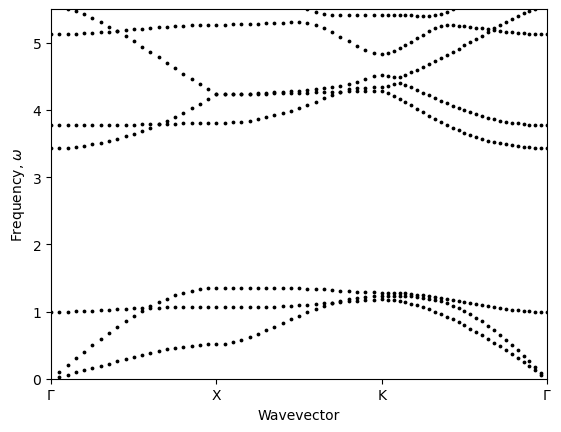

In [9]:
plt.scatter(wave_vecs, eigfreq, c='k', s=3)
plt.xticks([0, 1, 2, 3], ["$\Gamma$", "X", "K", "$\Gamma$"])
plt.xlim([0, 3])
plt.ylim([0, 5.5])
plt.xlabel("Wavevector")
plt.ylabel("Frequency, $\\omega$")
plt.show()

# References

1. Maurin et al., "Probability that a band-gap extremum is located on the irreducible Brillouin-zone contour for the 17 different plane crystallographic lattices", _Int. J. Solids Struct._, 135, pp. 26-36. https://doi.org/10.1016/j.ijsolstr.2017.11.006